# Install dependencies

In [ ]:
!pip install librosa matplotlib pandas pillow requests git+https://github.com/Peltarion/sidekick#egg=sidekick

# Load dependencies

In [2]:
import random

import librosa as lr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sidekick
from IPython.display import Audio
from PIL import Image
from ipywidgets import interact_manual

# Download test data from dcase 2018 competition
For more information, regarding the contents and license see [this page](https://zenodo.org/record/2552860#.XIpVoIU8twF).

In [ ]:
!curl https://zenodo.org/record/2552860/files/FSDKaggle2018.meta.zip?download=1 -o meta.zip
!curl https://zenodo.org/record/2552860/files/FSDKaggle2018.audio_test.zip?download=1 -o test.zip
!unzip -q meta.zip
!unzip -q test.zip

# Evaluate platform model
## Define mel spectrogram transform

In [4]:
def melspec(audio: np.ndarray, sample_rate: int):
    # Compute short fourier transform, complex value STFT
    stft = lr.stft(
        audio,
        hop_length=512,
        n_fft=1024,
        center=False
    )

    # Real value spectrogram
    spectrogram = np.abs(stft) ** 2.0

    # Mel basis
    mel_basis = lr.filters.mel(
        sample_rate,
        n_fft=1024,
        n_mels=128,
        fmax=sample_rate / 2,
        fmin=20
    )

    # Mel spectrogram
    mel_spectrogram = np.dot(mel_basis, spectrogram)
    
    # Rescale to dB
    db_mel_spectrogram = lr.power_to_db(mel_spectrogram, ref=np.max)

    # Rescale to the range [0, 255]
    scaled = (db_mel_spectrogram + 80) / 80 * 255
    scaled = scaled.astype(np.uint8)
    return scaled


def random_crop(arr: np.ndarray, size: int):
    n = arr.shape[1]
    i_start = random.randint(0, arr.shape[1] - size - 1)
    i_end = i_start + size
    return arr[:, i_start:i_end, ...]


def to_image(arr: np.ndarray) -> Image:
    image = Image.fromarray(arr)
    image.format = 'png'
    return image

## Connect to deployment

In [5]:
deployment = sidekick.Deployment(
    url='<url>',
    token='<token>'
)

## Load dataset metadata

In [6]:
df = pd.read_csv('FSDKaggle2018.meta/test_post_competition_scoring_clips.csv')

# Add relative path to wav-file
df['path'] = 'FSDKaggle2018.audio_test/' + df['fname']

# Sanity check head
df.head()

,fname,label,usage,freesound_id,license,path
0,00326aa9.wav,Oboe,Private,355125,Attribution,FSDKaggle2018.audio_test/00326aa9.wav
1,0038a046.wav,Bass_drum,Private,90621,Creative Commons 0,FSDKaggle2018.audio_test/0038a046.wav
2,007759c4.wav,Saxophone,Private,13406,Creative Commons 0,FSDKaggle2018.audio_test/007759c4.wav
3,008afd93.wav,Saxophone,Private,358962,Attribution,FSDKaggle2018.audio_test/008afd93.wav
4,00ae03f6.wav,Chime,Private,78203,Attribution,FSDKaggle2018.audio_test/00ae03f6.wav


## Pick one sample randomly

,fname,label,usage,freesound_id,license,path
321,38957ab8.wav,Knock,Private,83910,Creative Commons 0,FSDKaggle2018.audio_test/38957ab8.wav


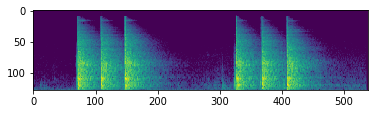

In [7]:
# Pick one sample
sample = df.sample(n=1)
audio, sr = lr.load(sample['path'].iloc[0], sr=44100)
mel = melspec(audio, sr)

# Show metadata, audio player and mel spectrogram
display(sample, Audio(data=audio, rate=sr))
plt.imshow(np.flip(mel, axis=0))
plt.show()

## Perform a prediction for a random crop
Runs on a new random crop each time it is pressed, which means results may vary.

In [8]:
@interact_manual
def show_prediction():
    # predict
    prediction = deployment.predict(
        fname=to_image(random_crop(mel, size=128)))
    
    # show top scores
    scores = sorted(prediction.items(), key=lambda item: item[1])
    top_labels, top_scores = zip(*scores[-5:])
    plt.barh(top_labels, top_scores)
    plt.show()

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…